<a href="https://colab.research.google.com/github/Priyank315660/ML-Model/blob/main/TorchVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import torch
import numpy as np
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
from google.colab.patches import cv2_imshow

In [ ]:
print("Upload an image with a person:")
uploaded_person = files.upload()

Upload an image with a person:


Saving f51d0a59def3381376fbbb99fb7c4825.jpg to f51d0a59def3381376fbbb99fb7c4825 (1).jpg


In [ ]:
print("Upload a background image:")
uploaded_bg = files.upload()

Upload a background image:


Saving 360_F_545428173_uyYWJoR9n5uJFYIWfDa2C49AzIECcU20.jpg to 360_F_545428173_uyYWJoR9n5uJFYIWfDa2C49AzIECcU20 (1).jpg


In [ ]:
person_image_path = "/content/f51d0a59def3381376fbbb99fb7c4825 (1).jpg"  # Replace with your actual image file
background_image_path = "/content/360_F_545428173_uyYWJoR9n5uJFYIWfDa2C49AzIECcU20 (1).jpg"  # Replace with your actual image file

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
person_img = Image.open(person_image_path).convert("RGB")
background_img = Image.open(background_image_path).convert("RGB")
background_img = background_img.resize(person_img.size)

# Convert to NumPy format
img_resized = person_img.resize((640, 480))
img_np = np.array(img_resized)



In [ ]:
input_tensor = transform(img_resized).unsqueeze(0)
with torch.no_grad():
    output = model(input_tensor)['out'][0]

# Generate segmentation mask (15 = Person Class)
mask = output.argmax(0).byte().cpu().numpy()
binary_mask = (mask == 15).astype(np.uint8) * 255  # Convert to 0 & 255

# Resize mask to original image size
binary_mask = cv2.resize(binary_mask, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_NEAREST)



In [ ]:
foreground = cv2.bitwise_and(img_np, img_np, mask=binary_mask)
inverse_mask = cv2.bitwise_not(binary_mask)
background_np = np.array(background_img)
background_np = cv2.resize(background_np, (binary_mask.shape[1], binary_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
background_part = cv2.bitwise_and(background_np, background_np, mask=inverse_mask)
# Merge foreground and background
final_image = cv2.add(foreground, background_part)

# 🔹 Convert BGR to RGB to Fix Color Issue
final_image_rgb = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)


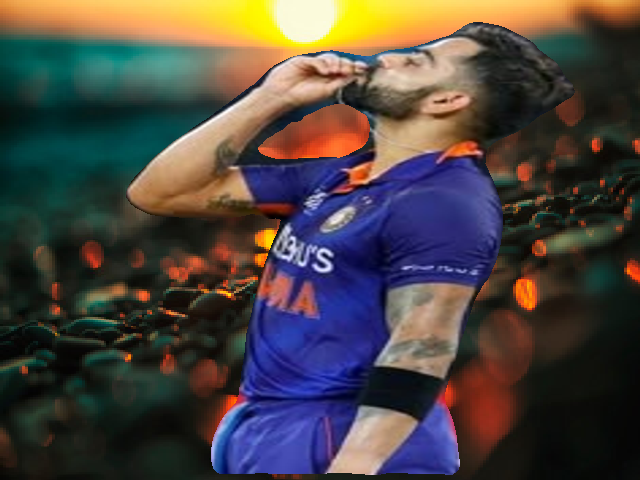

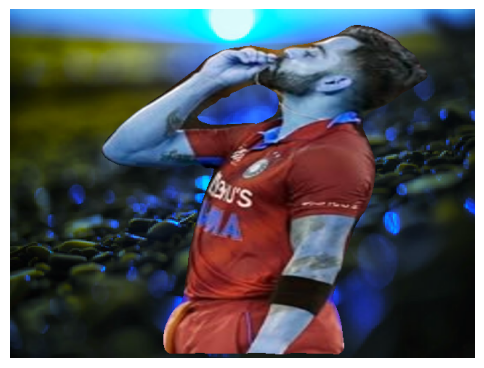

In [ ]:
cv2_imshow(final_image_rgb)
plt.figure(figsize=(6, 6))
plt.imshow(final_image_rgb)  # No need to convert again
plt.axis("off")
plt.show()